# 03 - Model Training & Evaluation

## Ziel
Trainiere und vergleiche verschiedene ML-Modelle zur Vorhersage von Bildungserfolg.

## Target Variable
**high_education:** Binäre Klassifikation (>= 12 Bildungsjahre = 1, sonst = 0)

## Features
- **SOEP Individual:** einkommenj1, anz_kind, anz_pers, gesund_org, lebensz_org
- **INKAR Regional:** arbeitslosenquote, kinderarmut, abiturquote, betreuungsquote, medianeinkommen

## Modelle
1. **Baseline** (Dummy Classifier - immer häufigste Klasse)
2. **Logistic Regression** (lineares Modell)
3. **Random Forest** (Ensemble)
4. **XGBoost** (Gradient Boosting)
5. **Gradient Boosting** (sklearn)

## Metriken
- Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Confusion Matrix
- Feature Importance

---
## Imports

In [1]:
# Pandas für DataFrames
import pandas as pd

# NumPy für numerische Operationen
import numpy as np

# Matplotlib für Plots
import matplotlib.pyplot as plt

# Seaborn für erweiterte Visualisierungen
import seaborn as sns

# Path für Dateipfade
from pathlib import Path

# Warnings unterdrücken für saubere Ausgabe
import warnings
warnings.filterwarnings('ignore')

# Train-Test Split
from sklearn.model_selection import train_test_split

# Scaler für Standardisierung
from sklearn.preprocessing import StandardScaler

# Baseline Model
from sklearn.dummy import DummyClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting (sklearn)
from sklearn.ensemble import GradientBoostingClassifier

# XGBoost
import xgboost as xgb

# Metriken
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

# Time für Training-Zeit
import time

# Setze Plot-Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Zeige alle Spalten
pd.set_option('display.max_columns', None)

# Plots inline
%matplotlib inline

---
## 1. Daten laden

In [2]:
# Pfad zur Datei mit regionalen Daten
data_path = '../data/processed/soep_with_regions.csv'

# Prüfe ob Datei existiert
if not Path(data_path).exists():
    # Fehlermeldung
    print('FEHLER: soep_with_regions.csv nicht gefunden!')
    print('Bitte zuerst 02_regional_clustering.ipynb ausführen.')
else:
    # Lade CSV
    df = pd.read_csv(data_path)
    # Info
    print(f'Geladen: {len(df)} Zeilen, {len(df.columns)} Spalten')

Geladen: 21753 Zeilen, 24 Spalten


In [3]:
# Zeige erste Zeilen
df.head()

,id,syear,sex,alter,anz_pers,anz_kind,bildung,erwerb,branche,gesund_org,lebensz_org,einkommenj1,einkommenj2,einkommenm1,einkommenm2,high_education,region_cluster,matched_bundesland,arbeitslosenquote,schulabg_ohne_abschluss,abiturquote,betreuungsquote,medianeinkommen,kinderarmut
0,194.0,2015.0,[1] female,59.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,4.0,6.0,28678.943359,0.0,1659.128540,0.0,0,0,Bremen,10.88,8.06,33.81,86.40,3241.01,NaN
1,194.0,2016.0,[1] female,60.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,3.0,5.0,19962.292969,0.0,1809.336426,0.0,0,9,Niedersachsen,5.97,5.78,37.97,89.65,3067.57,14.47
2,194.0,2017.0,[1] female,61.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,3.0,7.0,22227.675781,0.0,1849.037476,0.0,0,0,Bremen,10.17,8.17,36.25,83.90,3387.52,31.74
3,194.0,2018.0,[1] female,62.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,5.0,5.0,22100.378906,0.0,1616.513672,0.0,0,5,Schleswig-Holstein,5.48,8.49,35.38,89.37,3062.37,15.60
4,194.0,2019.0,[1] female,63.0,2.0,0.0,10.5,[-2] Employed part-time,[84] Public administration and defense; compul...,4.0,6.0,23157.919922,0.0,1901.001221,0.0,0,11,Thüringen,5.27,8.94,32.73,95.08,2689.95,12.00


---
## 2. Target Variable erstellen

In [4]:
# Erstelle high_education falls noch nicht vorhanden
if 'high_education' not in df.columns:
    # Prüfe ob bildung existiert
    if 'bildung' in df.columns:
        # Erstelle binäre Variable: 1 wenn >= 12 Bildungsjahre
        df['high_education'] = (df['bildung'] >= 12).astype(int)
        print('high_education erstellt: 1 wenn bildung >= 12, sonst 0')
    else:
        print('FEHLER: bildung-Spalte nicht gefunden!')
        raise ValueError('bildung-Spalte fehlt')

# Zeige Verteilung
print('\nTarget-Verteilung:')
print(df['high_education'].value_counts())
print(f'\nAnteil high_education=1: {df["high_education"].mean()*100:.1f}%')


Target-Verteilung:
high_education
0    14330
1     7423
Name: count, dtype: int64

Anteil high_education=1: 34.1%


---
## 3. Feature Selection

In [5]:
# Liste aller potentiellen Features
feature_candidates = [
    # SOEP Individual
    'einkommenj1',              # Jahreseinkommen
    'anz_kind',                 # Anzahl Kinder
    'anz_pers',                 # Haushaltsgröße
    'gesund_org',               # Gesundheit (1-5)
    'lebensz_org',              # Lebenszufriedenheit (0-10)
    'syear',                    # Jahr
    # INKAR Regional
    'arbeitslosenquote',        # Arbeitslosigkeit (%)
    'schulabg_ohne_abschluss',  # Schulabgänger ohne Abschluss (%)
    'abiturquote',              # Abiturquote (%)
    'kinderarmut',              # Kinderarmut (%)
    'betreuungsquote',          # Betreuungsquote (%)
    'medianeinkommen'           # Medianeinkommen (Euro)
]

# Filtere nur vorhandene Features
features = [f for f in feature_candidates if f in df.columns]

# Zeige verfügbare Features
print(f'Verfügbare Features: {len(features)}')
for f in features:
    print(f'  - {f}')

Verfügbare Features: 12
  - einkommenj1
  - anz_kind
  - anz_pers
  - gesund_org
  - lebensz_org
  - syear
  - arbeitslosenquote
  - schulabg_ohne_abschluss
  - abiturquote
  - kinderarmut
  - betreuungsquote
  - medianeinkommen


In [6]:
# Prüfe fehlende Werte
print('Fehlende Werte pro Feature:')
missing = df[features + ['high_education']].isnull().sum()
print(missing[missing > 0])

# Berechne vollständige Fälle
complete_cases = df[features + ['high_education']].dropna()
print(f'\nVollständige Fälle: {len(complete_cases)} von {len(df)}')

Fehlende Werte pro Feature:
anz_kind         59
anz_pers         59
gesund_org       83
lebensz_org     112
kinderarmut    5141
dtype: int64

Vollständige Fälle: 16505 von 21753


---
## 4. Data Preparation

In [7]:
# Erstelle X (Features) und y (Target)
# Nur vollständige Fälle verwenden
df_clean = df[features + ['high_education']].dropna()

# X: Feature-Matrix
X = df_clean[features].values

# y: Target-Vektor
y = df_clean['high_education'].values

# Info
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'\nTarget distribution:')
print(f'  Class 0: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)')
print(f'  Class 1: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)')

X shape: (16505, 12)
y shape: (16505,)

Target distribution:
  Class 0: 10775 (65.3%)
  Class 1: 5730 (34.7%)


In [8]:
# Train-Test Split: 80% Training, 20% Test
# stratify=y: gleiche Klassen-Verteilung in Train und Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Info
print(f'Training Set: {X_train.shape[0]} Samples')
print(f'Test Set: {X_test.shape[0]} Samples')
print(f'\nTrain Class 1: {(y_train==1).sum()/len(y_train)*100:.1f}%')
print(f'Test Class 1: {(y_test==1).sum()/len(y_test)*100:.1f}%')

Training Set: 13204 Samples
Test Set: 3301 Samples

Train Class 1: 34.7%
Test Class 1: 34.7%


In [9]:
# Standardisierung: Mean=0, Std=1
# Wichtig: fit nur auf Training-Daten
scaler = StandardScaler()

# Fit Scaler auf Training-Daten
X_train_scaled = scaler.fit_transform(X_train)

# Transform Test-Daten (NICHT fit!)
X_test_scaled = scaler.transform(X_test)

# Info
print('Daten standardisiert')
print(f'Train mean: {X_train_scaled.mean(axis=0).round(2)}')
print(f'Train std: {X_train_scaled.std(axis=0).round(2)}')

Daten standardisiert
Train mean: [ 0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0.  0.]
Train std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


---
## 5. Model Training

### 5.1 Baseline Model

In [10]:
# Baseline: Immer häufigste Klasse vorhersagen
# strategy='most_frequent': immer die Klasse die am häufigsten vorkommt
baseline = DummyClassifier(strategy='most_frequent', random_state=42)

# Starte Timer
start = time.time()

# Trainiere Baseline
baseline.fit(X_train_scaled, y_train)

# Stoppe Timer
baseline_time = time.time() - start

# Vorhersage auf Test-Set
y_pred_baseline = baseline.predict(X_test_scaled)

# Vorhersage-Wahrscheinlichkeiten (für ROC-AUC)
y_proba_baseline = baseline.predict_proba(X_test_scaled)[:, 1]

# Info
print('Baseline Model trainiert')
print(f'Training Time: {baseline_time:.3f}s')

Baseline Model trainiert
Training Time: 0.001s


### 5.2 Logistic Regression

In [11]:
# Logistic Regression: Lineares Modell
# max_iter=1000: maximale Iterationen für Konvergenz
# random_state=42: Reproduzierbarkeit
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Starte Timer
start = time.time()

# Trainiere Modell
logreg.fit(X_train_scaled, y_train)

# Stoppe Timer
logreg_time = time.time() - start

# Vorhersage
y_pred_logreg = logreg.predict(X_test_scaled)
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Info
print('Logistic Regression trainiert')
print(f'Training Time: {logreg_time:.3f}s')

Logistic Regression trainiert
Training Time: 0.056s


### 5.3 Random Forest

In [12]:
# Random Forest: Ensemble aus vielen Entscheidungsbäumen
# n_estimators=100: Anzahl Bäume
# max_depth=10: maximale Tiefe pro Baum (verhindert Overfitting)
# random_state=42: Reproduzierbarkeit
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Nutze alle CPU-Kerne
)

# Starte Timer
start = time.time()

# Trainiere Modell
rf.fit(X_train_scaled, y_train)

# Stoppe Timer
rf_time = time.time() - start

# Vorhersage
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Info
print('Random Forest trainiert')
print(f'Training Time: {rf_time:.3f}s')

Random Forest trainiert
Training Time: 0.544s


### 5.4 XGBoost

In [13]:
# XGBoost: Gradient Boosting optimiert für Performance
# n_estimators=100: Anzahl Boosting-Runden
# max_depth=5: maximale Baum-Tiefe
# learning_rate=0.1: Lernrate (kleinere Werte = langsameres Lernen)
# random_state=42: Reproduzierbarkeit
xgboost = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'  # Metric für Training
)

# Starte Timer
start = time.time()

# Trainiere Modell
xgboost.fit(X_train_scaled, y_train)

# Stoppe Timer
xgboost_time = time.time() - start

# Vorhersage
y_pred_xgboost = xgboost.predict(X_test_scaled)
y_proba_xgboost = xgboost.predict_proba(X_test_scaled)[:, 1]

# Info
print('XGBoost trainiert')
print(f'Training Time: {xgboost_time:.3f}s')

XGBoost trainiert
Training Time: 0.165s


### 5.5 Gradient Boosting (sklearn)

In [14]:
# Gradient Boosting: sklearn Implementation
# n_estimators=100: Anzahl Boosting-Stufen
# max_depth=3: maximale Tiefe pro Baum
# learning_rate=0.1: Lernrate
# random_state=42: Reproduzierbarkeit
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Starte Timer
start = time.time()

# Trainiere Modell
gb.fit(X_train_scaled, y_train)

# Stoppe Timer
gb_time = time.time() - start

# Vorhersage
y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

# Info
print('Gradient Boosting trainiert')
print(f'Training Time: {gb_time:.3f}s')

Gradient Boosting trainiert
Training Time: 1.777s


---
## 6. Model Evaluation

### 6.1 Metriken berechnen

In [15]:
# Funktion um alle Metriken für ein Modell zu berechnen
def calculate_metrics(y_true, y_pred, y_proba, model_name, training_time):
    """
    Berechne alle Evaluation-Metriken
    
    Parameters:
    -----------
    y_true : array
        Wahre Labels
    y_pred : array
        Vorhergesagte Labels
    y_proba : array
        Vorhergesagte Wahrscheinlichkeiten
    model_name : str
        Name des Modells
    training_time : float
        Training-Zeit in Sekunden
    
    Returns:
    --------
    dict mit allen Metriken
    """
    # Berechne Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Berechne Precision (von allen als 1 vorhergesagten, wie viele sind wirklich 1?)
    prec = precision_score(y_true, y_pred, zero_division=0)
    
    # Berechne Recall (von allen echten 1, wie viele wurden gefunden?)
    rec = recall_score(y_true, y_pred, zero_division=0)
    
    # Berechne F1-Score (harmonisches Mittel von Precision und Recall)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Berechne ROC-AUC (Fläche unter ROC-Kurve)
    auc = roc_auc_score(y_true, y_proba)
    
    # Gib Dictionary zurück
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'Training Time (s)': training_time
    }

# Berechne Metriken für alle Modelle
results = []

# Baseline
results.append(calculate_metrics(y_test, y_pred_baseline, y_proba_baseline, 'Baseline', baseline_time))

# Logistic Regression
results.append(calculate_metrics(y_test, y_pred_logreg, y_proba_logreg, 'Logistic Regression', logreg_time))

# Random Forest
results.append(calculate_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest', rf_time))

# XGBoost
results.append(calculate_metrics(y_test, y_pred_xgboost, y_proba_xgboost, 'XGBoost', xgboost_time))

# Gradient Boosting
results.append(calculate_metrics(y_test, y_pred_gb, y_proba_gb, 'Gradient Boosting', gb_time))

# Erstelle DataFrame
results_df = pd.DataFrame(results)

# Sortiere nach ROC-AUC (beste zuerst)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

# Zeige Tabelle
print('\nMODEL COMPARISON')
print('=' * 80)
results_df


MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s)
3,XGBoost,0.870645,0.965071,0.650960,0.777488,0.875826,0.165394
4,Gradient Boosting,0.871857,0.981358,0.643106,0.777016,0.872007,1.777184
2,Random Forest,0.872160,0.975066,0.648342,0.778826,0.869401,0.544243
1,Logistic Regression,0.844593,0.888344,0.631763,0.738399,0.825388,0.055938
0,Baseline,0.652832,0.000000,0.000000,0.000000,0.500000,0.001037


In [16]:
# Speichere Ergebnis-Tabelle
results_df.to_csv('../data/processed/model_comparison.csv', index=False)
print('Ergebnis-Tabelle gespeichert: model_comparison.csv')

Ergebnis-Tabelle gespeichert: model_comparison.csv


### 6.2 Confusion Matrices

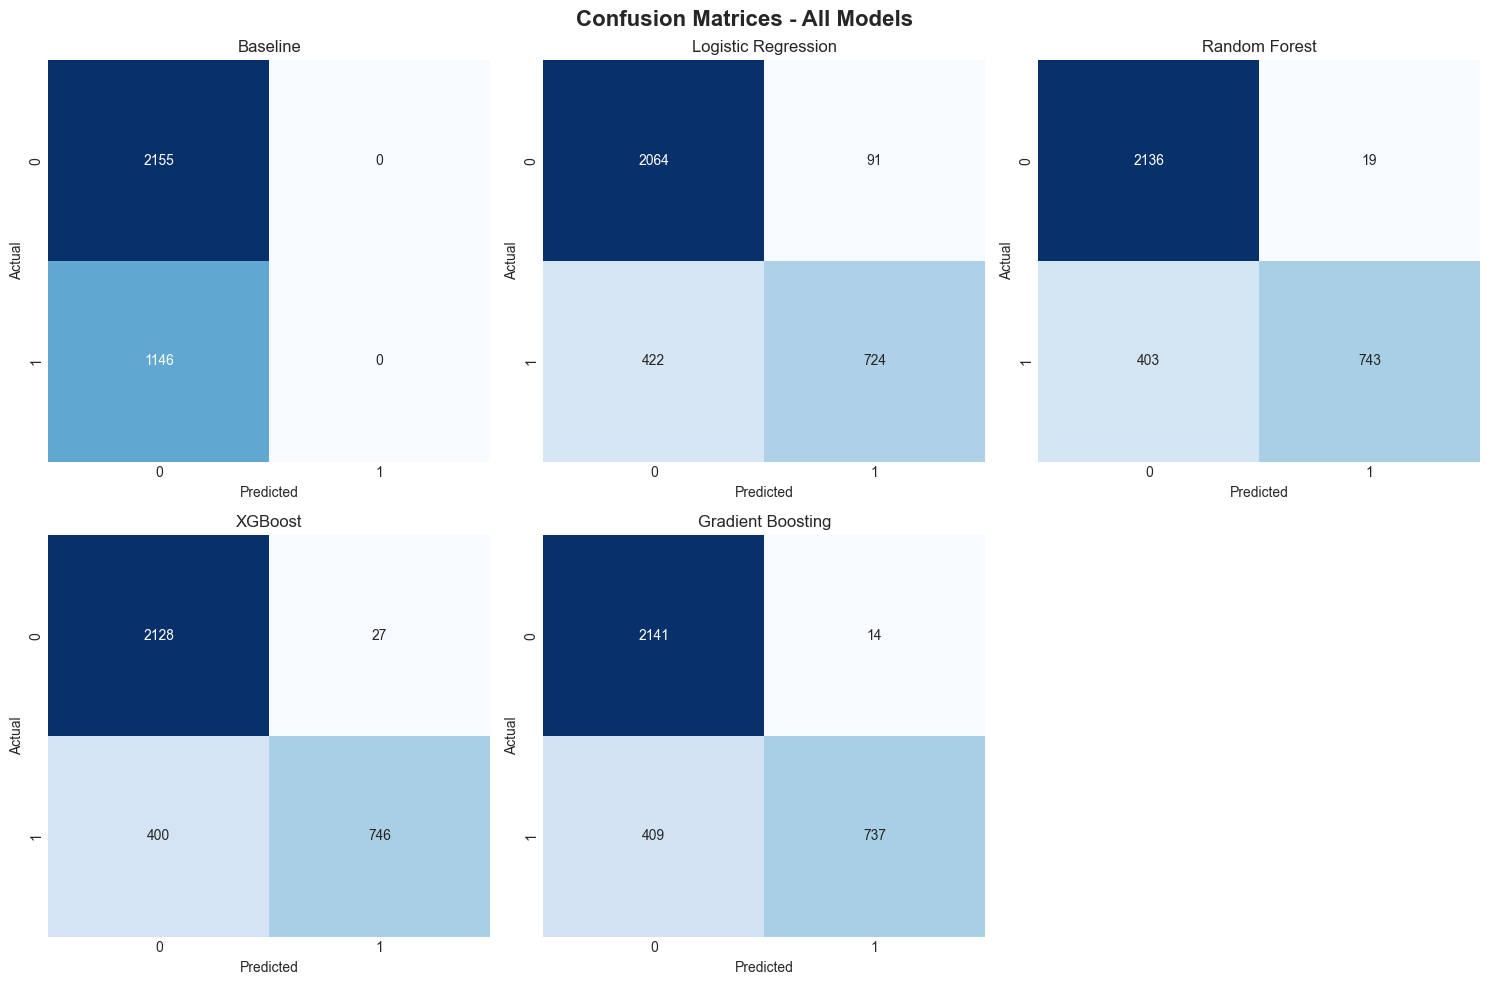

In [17]:
# Erstelle Figure mit 2x3 Subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes für einfacheren Zugriff
axes = axes.flatten()

# Liste der Modelle und Vorhersagen
models_preds = [
    ('Baseline', y_pred_baseline),
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgboost),
    ('Gradient Boosting', y_pred_gb)
]

# Iteriere durch Modelle
for idx, (model_name, y_pred) in enumerate(models_preds):
    # Berechne Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Zeichne Heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar=False
    )
    
    # Setze Labels
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{model_name}')

# Entferne letzten (leeren) Subplot
fig.delaxes(axes[5])

# Titel
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

# Layout
plt.tight_layout()

# Speichere
plt.savefig('../data/processed/confusion_matrices.png', dpi=300, bbox_inches='tight')

# Zeige
plt.show()

### 6.3 ROC Curves

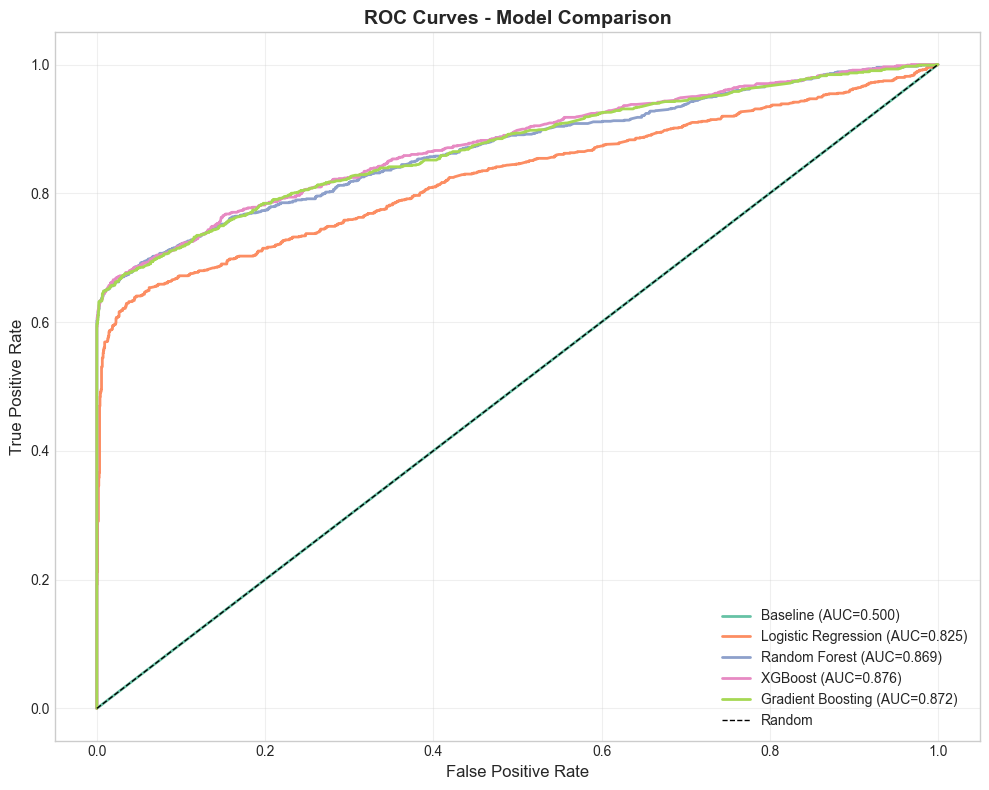

In [18]:
# Erstelle Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Liste der Modelle und Wahrscheinlichkeiten
models_probas = [
    ('Baseline', y_proba_baseline),
    ('Logistic Regression', y_proba_logreg),
    ('Random Forest', y_proba_rf),
    ('XGBoost', y_proba_xgboost),
    ('Gradient Boosting', y_proba_gb)
]

# Iteriere durch Modelle
for model_name, y_proba in models_probas:
    # Berechne ROC-Kurve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Berechne AUC
    auc = roc_auc_score(y_test, y_proba)
    
    # Zeichne Kurve
    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc:.3f})')

# Diagonale (Random Classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')

# Labels
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')

# Legende
ax.legend(loc='lower right', fontsize=10)

# Grid
ax.grid(True, alpha=0.3)

# Layout
plt.tight_layout()

# Speichere
plt.savefig('../data/processed/roc_curves.png', dpi=300, bbox_inches='tight')

# Zeige
plt.show()

---
## 7. Feature Importance

Nur für Baum-basierte Modelle: Random Forest, XGBoost, Gradient Boosting

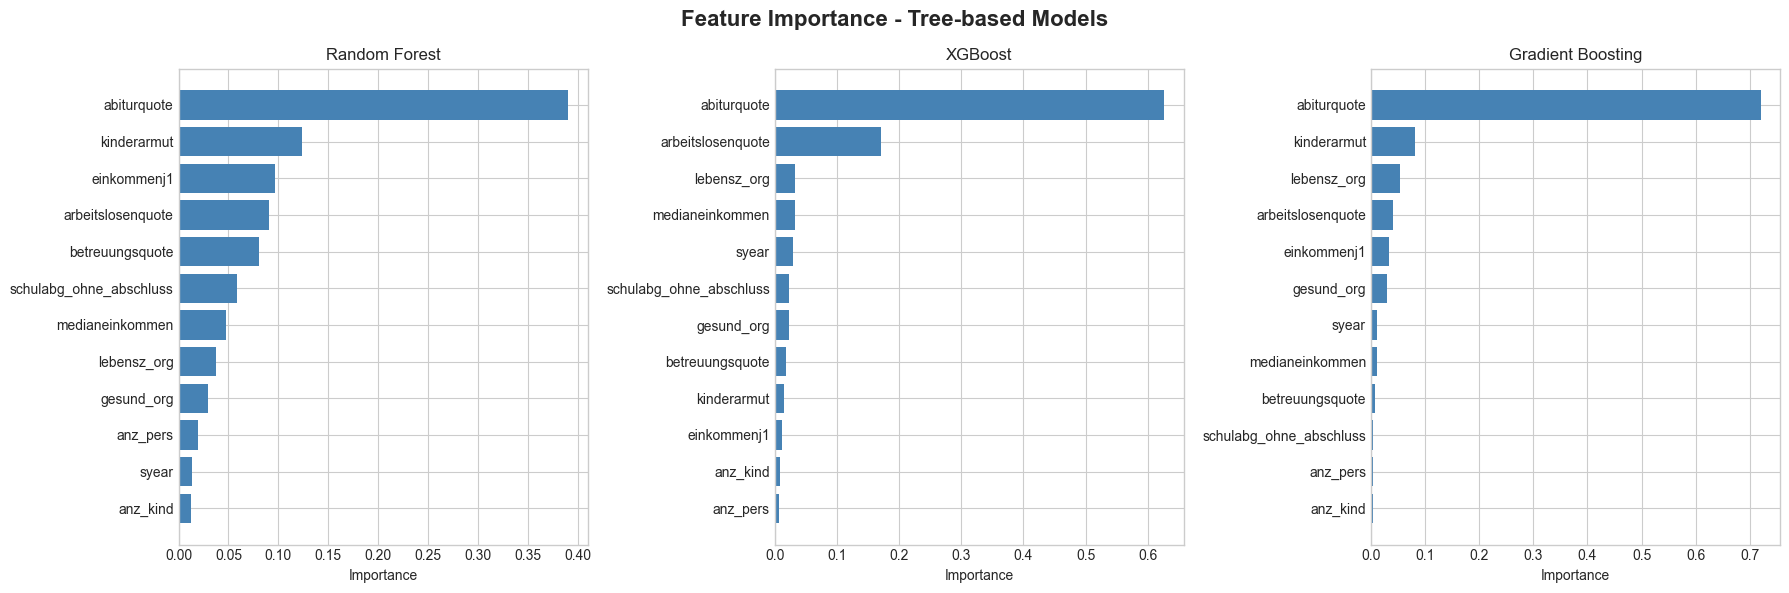

In [19]:
# Erstelle Feature-Namen DataFrame
feature_names = features

# Erstelle Figure mit 3 Subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Liste der Baum-basierten Modelle
tree_models = [
    ('Random Forest', rf),
    ('XGBoost', xgboost),
    ('Gradient Boosting', gb)
]

# Iteriere durch Modelle
for idx, (model_name, model) in enumerate(tree_models):
    # Hole Feature Importance
    importances = model.feature_importances_
    
    # Erstelle DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Zeichne Balkendiagramm
    axes[idx].barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    
    # Labels
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{model_name}')
    
    # Invertiere Y-Achse (wichtigste oben)
    axes[idx].invert_yaxis()

# Titel
fig.suptitle('Feature Importance - Tree-based Models', fontsize=16, fontweight='bold')

# Layout
plt.tight_layout()

# Speichere
plt.savefig('../data/processed/feature_importance.png', dpi=300, bbox_inches='tight')

# Zeige
plt.show()

In [20]:
# Zeige Top 10 Features für bestes Modell
# Finde bestes Modell (höchste ROC-AUC)
best_model_name = results_df.iloc[0]['Model']

# Hole entsprechendes Modell
if best_model_name == 'Random Forest':
    best_model = rf
elif best_model_name == 'XGBoost':
    best_model = xgboost
elif best_model_name == 'Gradient Boosting':
    best_model = gb
else:
    best_model = None

# Zeige Feature Importance wenn verfügbar
if best_model is not None and hasattr(best_model, 'feature_importances_'):
    # Erstelle DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Zeige Top 10
    print(f'\nTop 10 Features - {best_model_name}')
    print('=' * 50)
    print(importance_df.head(10).to_string(index=False))


Top 10 Features - XGBoost
                Feature  Importance
            abiturquote    0.626888
      arbeitslosenquote    0.171742
            lebensz_org    0.033113
        medianeinkommen    0.032392
                  syear    0.028963
schulabg_ohne_abschluss    0.022968
             gesund_org    0.022867
        betreuungsquote    0.018161
            kinderarmut    0.014649
            einkommenj1    0.012270


---
## 8. Best Model speichern

In [21]:
# Importiere joblib zum Speichern
import joblib

# Finde bestes Modell
best_model_name = results_df.iloc[0]['Model']

# Hole entsprechendes Modell-Objekt
model_dict = {
    'Baseline': baseline,
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'XGBoost': xgboost,
    'Gradient Boosting': gb
}

best_model = model_dict[best_model_name]

# Speichere Modell
model_path = '../data/processed/best_model.pkl'
joblib.dump(best_model, model_path)

# Speichere auch Scaler
scaler_path = '../data/processed/scaler.pkl'
joblib.dump(scaler, scaler_path)

# Speichere Feature-Namen
feature_path = '../data/processed/feature_names.txt'
with open(feature_path, 'w') as f:
    for feature in feature_names:
        f.write(f'{feature}\n')

# Info
print(f'Bestes Modell: {best_model_name}')
print(f'Gespeichert: {model_path}')
print(f'Scaler gespeichert: {scaler_path}')
print(f'Features gespeichert: {feature_path}')

Bestes Modell: XGBoost
Gespeichert: ../data/processed/best_model.pkl
Scaler gespeichert: ../data/processed/scaler.pkl
Features gespeichert: ../data/processed/feature_names.txt


---
## 9. Zusammenfassung

### Trainierte Modelle
1.  Baseline (Dummy Classifier)
2.  Logistic Regression
3.  Random Forest
4.  XGBoost
5.  Gradient Boosting

### Evaluierte Metriken
- Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Confusion Matrices
- ROC Curves
- Feature Importance

### Gespeicherte Artefakte
- `model_comparison.csv` - Vergleichstabelle
- `best_model.pkl` - Bestes Modell
- `scaler.pkl` - Scaler für Vorhersagen
- `feature_names.txt` - Feature-Namen
- Visualisierungen: Confusion Matrices, ROC Curves, Feature Importance